### Deep Learning Supervised Text Classification
- BiLSTM (BDA + TrDA)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [1]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [4]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

In [ ]:
#!pip list -v
# programmatically with python
#!python -m site --user-site
#!pip list --user -v

### Load Data

In [7]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031323'  #'ppe non-compliance'
]

fn_bd_aug_names = [
    'hydraulic fluid or oil leak_4700_simple_da',
    'line strike_8091_simple_da',
    'site compliance or practice issue_8000_simple_da',
    'ppe non-compliance_8050_simple_da',
    'mechanical or equipment issue_8294_simple_da'
]

fn_tr_aug_names = [
    'hydraulic fluid or oil leak_7920_trda',
    'line strike_',
    'site compliance or practice issue_8410_trda',
    'ppe non-compliance_',
    'mechanical or equipment issue_'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: site compliance or practice issue


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [8]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [9]:
base_train_count = len(X_train)
base_train_count

75085

In [10]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 59 [13, 38, 710, 925, 1071, 1143, 1323, 1440, 2382, 2610, 4545, 5033, 5620, 6845, 6937, 7708, 8034, 8309, 9228, 9378, 9650, 9785, 10478, 10552, 10651, 10698, 10806, 10979, 11008, 11186, 11704, 14130, 15616, 16266, 16305, 16644, 16659, 18158, 18280, 18441, 18504, 22527, 23763, 24005, 25447, 26450, 26559, 38153, 38876, 51290, 62644, 62691, 72009, 72447, 74225, 79333, 86509, 86652, 92972]
Train: 341 [20, 58, 168, 370, 372, 507, 585, 606, 664, 764, 844, 869, 881, 949, 979, 1007, 1243, 1350, 1584, 1604, 1754, 1804, 1816, 1825, 1903, 1936, 2081, 2088, 2143, 2190, 2226, 2320, 2338, 2381, 2388, 2522, 2559, 2713, 2808, 2935, 3236, 3262, 3332, 3480, 3564, 3785, 3820, 3892, 4316, 4349, 4560, 4597, 4608, 4718, 4739, 4956, 5075, 5142, 5172, 5173, 5295, 5344, 5359, 5467, 5517, 5704, 5743, 5785, 5801, 5862, 5977, 6105, 6186, 6340, 6352, 6367, 6457, 6463, 6742, 6840, 6886, 7056, 7111, 7228, 7477, 7483, 7597, 7598, 7721, 7726, 7770, 7781, 7792, 7845, 7872, 7980, 8031, 8232, 8305, 8332, 8398, 8432

In [11]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
20,approximately fifteen litres of sewage overflo...,1
58,worker observed without appropriate fall prote...,1
168,lifting coordinator lc preparing to perform a ...,1
370,tm crossed outer ndt exclusion zone barricade ...,1
372,unsafe act individual knowingly crossed a barr...,1
...,...,...
88783,other fall to lower level six to ten feet whil...,1
90941,other fall to lower level six to ten feet an e...,1
91446,other fall to lower level sixteen to twenty fe...,1
91534,other fall to lower level eleven to fifteen fe...,1


### **Basic Data Augmentation (BDA) Experiments**

In [12]:
fn_bd_aug_names

['hydraulic fluid or oil leak_4700_simple_da',
 'line strike_8091_simple_da',
 'site compliance or practice issue_8000_simple_da',
 'ppe non-compliance_8050_simple_da',
 'mechanical or equipment issue_8294_simple_da']

In [13]:
# Load fabricated reports
fn_bd_name = fn_bd_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_bd_name}.csv')
df_fab

,text,category
0,preventable company fomite incident life savin...,1
1,preventable company vehicle incident life savi...,1
2,preventable company incident life saving rule ...,1
3,preventable company vehicle incidental life sa...,1
4,preventable company life saving rule breach no...,1
...,...,...
7995,other fall to lower level to a lesser extent t...,1
7996,other fall to lower level less than six spot f...,1
7997,other fall to lower level less than six mind f...,1
7998,other fall to backwards lower level less than ...,1


In [14]:
# Prepare data & conbine with original training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

In [15]:
# Complete the new training dataframe
df_shuff = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_shuff['category'] = y_train_list
df_shuff

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery n e c...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83080,other fall to lower level to a lesser extent t...,1
83081,other fall to lower level less than six spot f...,1
83082,other fall to lower level less than six mind f...,1
83083,other fall to backwards lower level less than ...,1


In [16]:
# Shuffle the dataframe
df_shuff = df_shuff.sample(frac=1).reset_index(drop=True)
df_shuff

,text,category
0,other fall to of protection unspecified an emp...,1
1,struck by object falling from vehicle or machi...,0
2,compressed or pinched by shifting objects or e...,0
3,shooting by other personintentional an employe...,0
4,compressed or pinched by shifting objects or e...,0
...,...,...
83080,theft of generator third incident trespasser e...,0
83081,caught in running equipment or machinery unspe...,0
83082,employees reported gunshots being fired from o...,0
83083,compressed or pinched by shifting objects or e...,0


In [17]:
# Visually check a random sample of 20 (hits)
df_shuff[df_shuff['category']==1].sample(20)

,text,category
11747,equipment operator discovers a knownmarked fou...,1
18090,excavating without permit to workcelbudeb the ...,1
41883,operator damaged one of the forks on the forkl...,1
82132,worker in aerial work program without using de...,1
77758,other fall to lower level eleven to fifteen fe...,1
9658,near miss with lsr violation cut into isolated...,1
28917,during routine permit audit a subcontractor pe...,1
70169,fall through surface or existing opening sixte...,1
57971,struck by the object or equipment n e c on fel...,1
76238,lifting coordinator lc preparing to perform a ...,1


In [18]:
X_train = df_shuff.text
y_train = df_shuff.category

### Transformer Data Augmentation (TrDA)

In [19]:
# Load fabricated reports
fn_tr_name = fn_tr_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_tr_name}.csv')
df_fab

,text,group
0,good practice not applied for investigation an...,site compliance or practice issue
1,good practice not applied,site compliance or practice issue
2,good practice not applied by law enforcement e...,site compliance or practice issue
3,good practice not applied see detailed descrip...,site compliance or practice issue
4,good practice not applied to contractors durin...,site compliance or practice issue
...,...,...
8405,failure to respect process or procedure as an ...,site compliance or practice issue
8406,failure to respect process or procedures or pe...,site compliance or practice issue
8407,failure to respect process or equipment incide...,site compliance or practice issue
8408,failure to respect process supervisor personne...,site compliance or practice issue


In [20]:
# Prepare data and augment raw (real) training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

In [21]:
df_shuff = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_shuff['category'] = y_train_list
df_shuff

,text,category
0,other fall to of protection unspecified an emp...,1
1,struck by object falling from vehicle or machi...,0
2,compressed or pinched by shifting objects or e...,0
3,shooting by other personintentional an employe...,0
4,compressed or pinched by shifting objects or e...,0
...,...,...
91490,failure to respect process or procedure as an ...,1
91491,failure to respect process or procedures or pe...,1
91492,failure to respect process or equipment incide...,1
91493,failure to respect process supervisor personne...,1


In [22]:
# Shuffle the dataframe
df_shuff = df_shuff.sample(frac=1).reset_index(drop=True)
df_shuff

,text,category
0,technician noticed he lost the ability to head...,1
1,employee dislocated his knee when he moved fro...,0
2,skid steer with auger bit attachment drilled i...,1
3,fall slip trip unspecified an employee was ver...,0
4,fall on same level due to slipping while walki...,0
...,...,...
91490,houston campus stallion building broken window...,0
91491,fall to lower level unspecified an employee wa...,0
91492,fa veolia walters foreign body left eye ks2017...,0
91493,theft at xto blue chain lighning while arrivin...,0


In [23]:
# Quick visual check of a random sample of 20 (hits)
df_shuff[df_shuff['category']==1].sample(20)

,text,category
50815,person did not apply good practice breach of c...,1
72448,individual did not follow normal practice whil...,1
75706,working height without full body harness e i c...,1
64671,person did not respect procedure of lifting on...,1
84112,a subcontractors was the a truck and th bumper...,1
63089,subcontractor was observed not wearing fall pr...,1
17799,hotel advised that two aim commissioning perso...,1
27837,crew did not respect site practice incident 33...,1
18093,crane block resting on pdc transformer at seve...,1
77138,apprentice did not respect site practice durin...,1


## Build Model

In [24]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [25]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [26]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [27]:
X_train = df_shuff.text
y_train = df_shuff.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [28]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 75265
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3763300   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [29]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].sample(20)

26559    electrical rcd flashed and burnt one of the pi...
18504    worker observed working at height without usin...
8309     employee pulls muscle in lower back employee w...
1323     scaffold modified by unqualified employee inci...
62644    other fall to lower level unspecified an emplo...
18158    tm was replacing looms using a battery operate...
16266    excavator operator swung into a swivel dump tr...
13       preventable company vehicle incident life savi...
92972    other fall to lower level less than six feet a...
9785     dot violation driver cited for being overweigh...
24005    wood employee was observed to be driving whils...
16659    mva reversed into parked vehicle a wood e i em...
9228     using mobile phone whilst driving at approx th...
5033     dot violation noimproper breakaway emergency b...
72009    other fall to lower level unspecified an emplo...
86652    nonroadway incident involving motorized land v...
2382     while wood was supervising a flushing preparat.

In [30]:
# Reminder of test set breakdown
Counter(y_test)

Counter({0: 18713, 1: 59})

In [31]:
# Verify augmented training set breakdown
Counter(y_train)

Counter({1: 16751, 0: 74744})

### Model Training & Evaluatrion

In [32]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [33]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 15076
Number of positives in validation data: 1675


In [ ]:
# Train the model
print('Training for:', focus_cat)
epoch_num = int(input('Enter epoch number (default is 3): '))
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=epoch_num,
                              batch_size=128,
                              verbose=1)

Training for: site compliance or practice issue
Enter epoch number (default is 3): 5
Epoch 1/5
 51/644 [=>............................] - ETA: 31:12 - loss: 0.0203 - categorical_accuracy: 0.8212

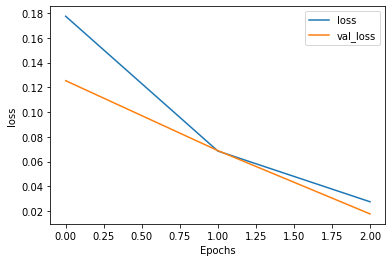

In [35]:
# Plot training history
plot_graphs(history, 'loss')

In [36]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18713
           1       0.34      0.88      0.49        59

    accuracy                           0.99     18772
   macro avg       0.67      0.94      0.75     18772
weighted avg       1.00      0.99      1.00     18772





In [37]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  59


In [39]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_bda_trda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book
13829,breach of permit controls and procedures by permit authority permit authority did not carry out a toolbox talk and back dated the time on the permit no injury occurred this is a control of work procedural breach work was stopped and pa has had pa status removed pending investigation,1,0
5930,"person displayed a change to normal and accepted behaviors following redundancy notification incident 31172relevant information saved in hr file and g bp contract 105957hse14 incident management201608 augustupstreamcairs thirty-one thousand, one hundred and seventy-two clair hr demobbrief summarywitnesshas worked as a rigger for wood group for three years most of that time has been assigned to a rotation working on bp clair about twelve thirty hours on friday 19th august two thousand and sixteen witness was contacted by wood group logistics to advise of his checkin time for mobilisation to bp clair on monday 22nd august with scheduled demobilisation being 12th september about twelve fifty hours same day witness was contacted by a staff member of thecontract construction team and hr tonotify him of his redundancy situation and associated advice on monday 22nd august witness did not mobilise to bp clair due to fog limits for flying and associated flight delays on tuesday 23rd august witness mobilised to bp clair and on arrival was advised of the need for him to join a work party engaged in the removal of rigging chain blocks his role being as standby man as the task was over side from that point on witness displayed a change to his normal behavior and became disruptive to team morale and work operations being carried out on realising this and the potential to impact on safety the offshore supervision team contactedthe contract team onshore to advise of the circumstances and seek advice after a discussion with witness on wednesday 24th august supervision acknowledged that witness had not changed his behaviors or adhered to any advice on same on thursday 25th august witness demobilised from the platform and was later interviewed by onshore hse and hr to ascertain full circumstances see action and reasoning for perceived behaviors displayed further states statement provided by wg ftl to assist hr process witness consultation pool clarified wrong pool but scored for the rigging pool same outcome witness updated on this by hr and construction coordinator staff update for closure on receiving guidance from hr on the matterin consultation with contract leadership witness is no longer with wg as a result of the consultation process hr have therefore placed a note in his file forviewing should he be considered for employment in the future all relevant items have been saved in g bp contract 105957hse14 incident management201608 augustupstreamcairs thirty-one thousand, one hundred and seventy-two clair hr demob see detailed description",1,0
6922,a group it employee was driving a personal vehicle from stallion bldg to thoroughbred bldg to perform it work and his vehicle collided with another vehicle while crossing innovation drive hsse investigation underway incident 30146a group it employee was driving a personal vehicle from stallion bldg to thoroughbred bldg to perform it work and his vehicle collided with another vehicle while crossing innovation drive hsse investigation is underway lsr eight observe speed limits and other traffic regulations employee was issued a citation failure to yield see detailed description,1,0
6909,inadequate wording of task description on wcc incident 30171during an issow audit at around nine 15am it appeared that the workparty were carrying out a task that was not covered on the wcc after discussing the task with the workparty a member of the audit team stopped the job the workparty understood the reason for stopping the job and reported back to their supervisor the workparty were preparing to remove a blind flange wcc is attached as the audit team were leaving the work site they spoke with the 


There are 100 entries (out of 59)...

Total no. of positive predictions is  152...

Total no. of positive hits is  52...


In [40]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
16266,excavator operator swung into a swivel dump truck through the course of the day an excavator was located inside an exclusion zone working on a culvert for basin thirty-five the excavator operator was loading soil onto a swivel dump truck in order to be hauled at about 3pm the swivel dump truck parked in proximity to the excavator during this time the excavator operator attempted to locate the swivel dump truck by swinging the excavator to the left causing the counterweight to make contact with the swivel dump truck stairs and wheel well incident is still under investigation operators are to complete a three hundred and sixty walk around in order to check clearance of counterweight prior of any movement unless swing radius is barricaded,0,1
9785,dot violation driver cited for being overweight wood dot driver was hauling a load of roadbase gravel in a 10yd dump truck traveling east on i90 and was stopped by the wyoming highway patrol for appearing to be overweight the load was heaped in the bed the patrolman had our driver proceed to a rest area where the surface was flat and he could safely perform a weight check the gvw of the dump truck was overweight the driver cited for being overweight driver was allowed to travel on the gravel county road to his destination and dump the load of roadbase,0,1
25447,minor property damage to fence post at wpc whilst constructing the security fence and trying to complete the finish level of the laydown pad at well pad c the d6 dozer pp127 contacted the fence post causing minor damage to the fence post area made safe and fence post to be removed and replaced,0,1
38,tag line came disconnected from load rigger at that time went to load to reconnect and was stopped immediately by picker operator crew was tasked to lift and place four hundred barrel steel tanks out of work area and on their sides the crew discussed during tail gate and pre planning meeting to rig up the tank through the equalizer hole in the tank with the tbar rigging due to the top of the tank was showing signs of corrosion this pick caused the tanks to pick at a forty-five degree angle to the ground the pick on the first tank was successful and during the pick of the second tank the tagline that had been placed above the hatch of the tank prior to the lift came disconnected at this time the rigger gathered up the tag line and proceeded to the load to attach it again the operator stated that they thought the rigger would attach it to the load out line valve which was on the side of the tank the operator stated that the rigger walked directly to the area where previously attached manufacturer plate above the side hatch which would placed him just under the suspended load the operator exercised stop work authority by immediately exiting the cab and informed the rigger to not get under the load and stay out of the danger zone the operator and rigger agreed to a safer position on the tank to attach the tagline to the job was started back up and task was successfully completed incident marked low due to employee was approaching to get under the bottom of the tank and under the suspended load but the job was stopped before the employee was in the line of fire job was stopped to get rigger from under the load job was reevaluated for a safer means of attachment of tagline operator filled out a heart card,0,1
22527,crane operator hit the fpso machine room vent at main deck while returning crane boom to nest after an unauthorized test no victims wood crane operator decided by himself to perform a test on the stiff leg crane after maintenance without a work permit he moved the crane boom to the right above the interferences which include the machine room vent and when was moving the boom to the left to return it back to the nest he hit the vent tip metal piece approx 300kg making it to disconnect from the vent and fell down approx 1m close to the escape route there were no people close to the point in a 10m ratio s


There are 7 entries (out of 59)...


In [42]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_bda_trda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))